# Final Project: Diabetes Prediction
Catherine McKay & Sam Bernsen

In [ ]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.neighbors import NearestNeighbors

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn import metrics 
from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.neighbors import KNeighborsClassifier # KNN

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV

In [ ]:
diabetes = pd.read_csv("diabetes_prediction_dataset.csv")

In [ ]:
diabetes.shape

(100000, 9)

In [ ]:
diabetes.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [ ]:
predictors = ["gender", "age", "hypertension", "heart_disease", "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"]
cont_predictors =  ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
outcome = "diabetes"

In [ ]:
X = diabetes[predictors]
y = diabetes[outcome]

## Q1:
When looking at scatter plots from the 3 features, bmi, age, blood_glucose_level, which clustering algorithm, GMM, KMeans, or DBSCAN result in the best silhouette score?

In [ ]:
diabetes.dropna(inplace = True)

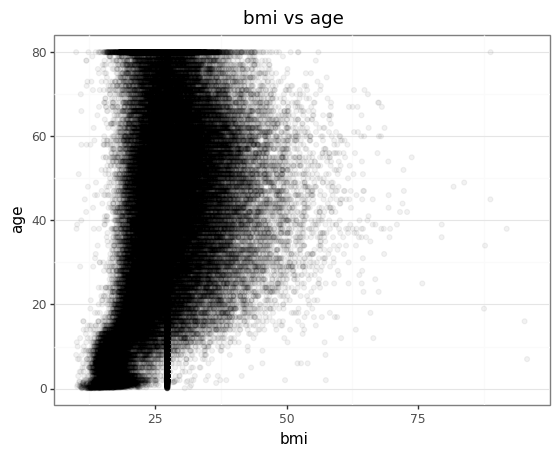

<ggplot: (8762712411575)>

In [ ]:
# construct scatter plot of bmi vs age 
(ggplot(diabetes, aes(x = "bmi", y = "age")) + 
 geom_point(alpha = 0.05) + 
 theme_bw() + 
 theme(panel_grid_major_x = element_blank()) +
 labs(title = "bmi vs age"))

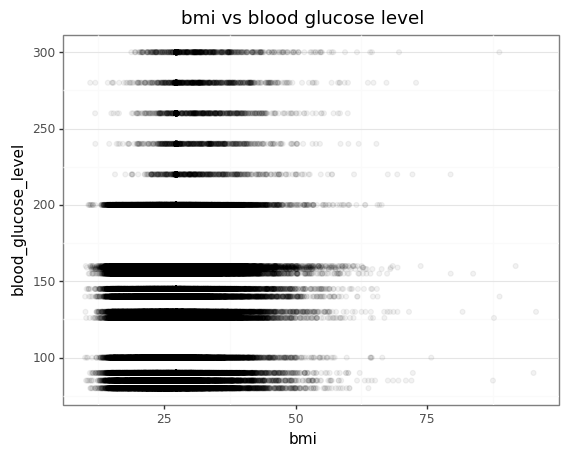

<ggplot: (8762773835885)>

In [ ]:
# construct scatter plot of bmi vs blood glucose level
(ggplot(diabetes, aes(x = "bmi", y = "blood_glucose_level")) + 
 geom_point(alpha = 0.05) + 
 theme_bw() + 
 theme(panel_grid_major_x = element_blank()) +
 labs(title = "bmi vs blood glucose level"))

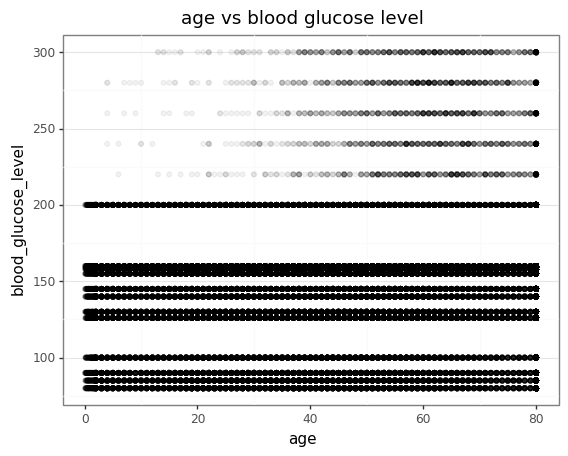

<ggplot: (8762712301064)>

In [ ]:
# construct scatter plot of age vs blood glucose level
(ggplot(diabetes, aes(x = "age", y = "blood_glucose_level")) + 
 geom_point(alpha = 0.05) + 
 theme_bw() + 
 theme(panel_grid_major_x = element_blank()) +
 labs(title = "age vs blood glucose level"))

Based on these plots, we will choose GMM because we do not have spherical clusters and there is little noise in our scatterplots.

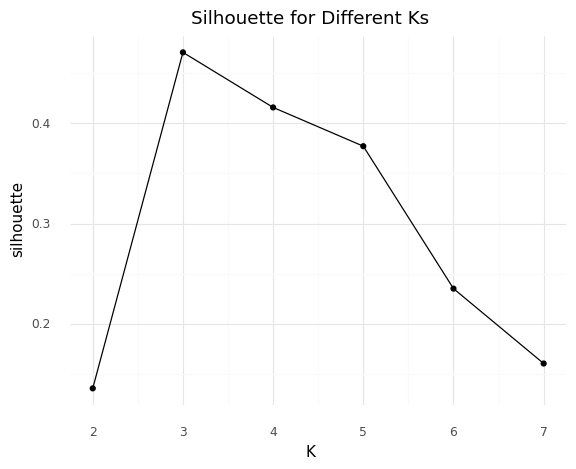

<ggplot: (8762711500500)>

In [ ]:
n_components = [2,3,4,5,6,7]

sils = []

for n in n_components:
  gmm = GaussianMixture(n_components=n)
  gmm.fit(diabetes[["bmi", "age", "blood_glucose_level"]])

  colName = "assignments" + str(n)
  clusters = gmm.predict(diabetes[["bmi", "age", "blood_glucose_level"]])

  diabetes[colName] = clusters

  sils.append(silhouette_score(diabetes[["bmi", "age", "blood_glucose_level"]], clusters))

sil_df = pd.DataFrame({"K": n_components,
                      "silhouette": sils})

# create line graph of silhouette scores to choose k
(ggplot(sil_df, aes(x = "K", y = "silhouette")) + geom_point() + 
geom_line() + 
theme_minimal() + 
labs(title = "Silhouette for Different Ks"))

In [ ]:
real_gmm = GaussianMixture(n_components=3)
real_gmm.fit(diabetes[["bmi", "age", "blood_glucose_level"]])

GaussianMixture(n_components=3)

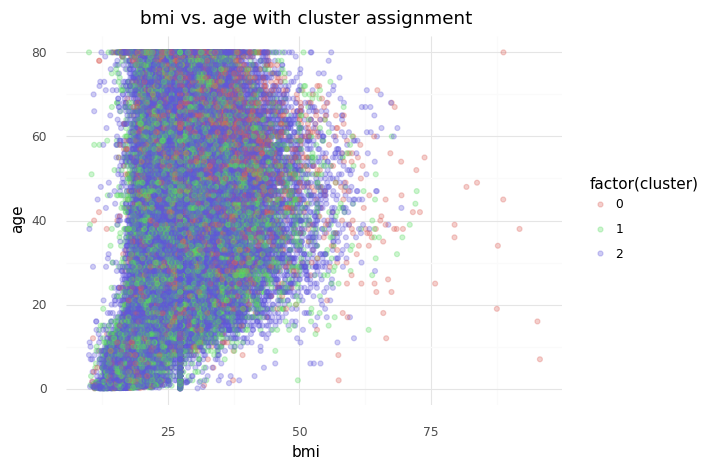

<ggplot: (8762711717372)>

In [ ]:
diabetes_cluster = diabetes


clusters = real_gmm.predict(diabetes[["bmi", "age", "blood_glucose_level"]])

diabetes_cluster["cluster"] = clusters

(ggplot(diabetes_cluster, aes(x = "bmi", y = "age", color = "factor(cluster)")) + geom_point(alpha = 0.3) + 
theme_minimal() + labs(title = "bmi vs. age with cluster assignment"))

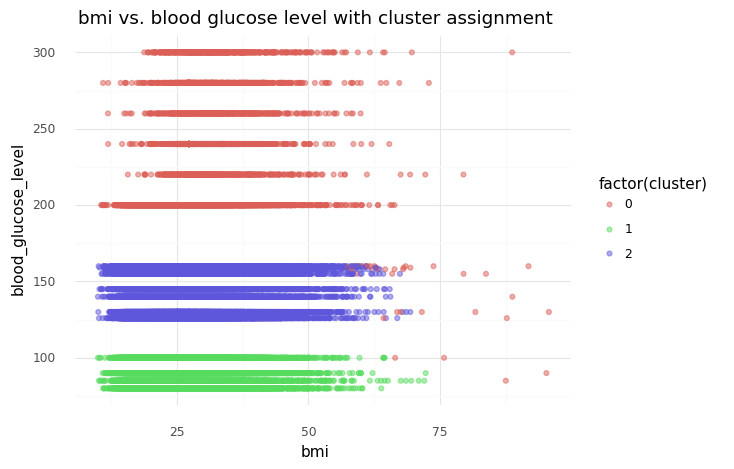

<ggplot: (8762711837357)>

In [ ]:
(ggplot(diabetes_cluster, aes(x = "bmi", y = "blood_glucose_level", color = "factor(cluster)")) + geom_point(alpha = 0.5) + 
theme_minimal() + labs(title = "bmi vs. blood glucose level with cluster assignment"))

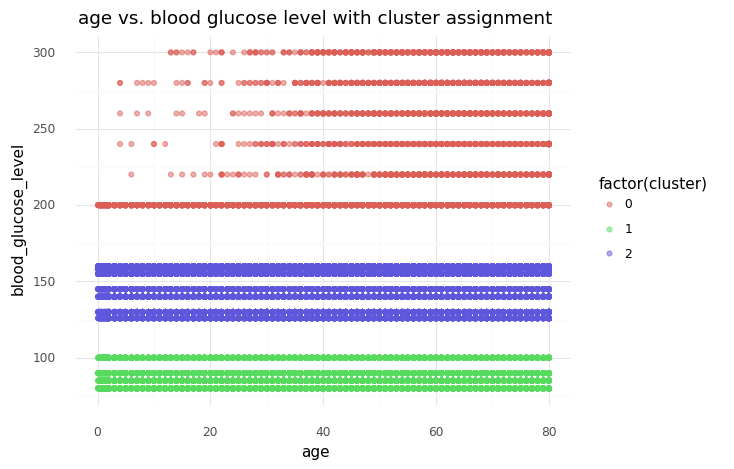

<ggplot: (8762695436976)>

In [ ]:
(ggplot(diabetes_cluster, aes(x = "age", y = "blood_glucose_level", color = "factor(cluster)")) + geom_point(alpha = 0.5) + 
theme_minimal() + labs(title = "age vs. blood glucose level with cluster assignment"))

In [ ]:
print(silhouette_score(diabetes[["bmi", "age", "blood_glucose_level"]], clusters))

0.4708425267059129


Our clustered scatterplots of bmi vs blood glucose level and age vs blood glucose level show that we have effectively clustered our data into three 
categories. A silhouette score of 0.47 is good enough to label distinct groups.
Group 0: This group has middling blood glucose levels.
Group 1. This group consistently has around 100 blood glucose level or lower, can be of any age, and generally does not have a high bmi.
Group 2: This group has high blood glucose levels and tends to be older people. We also see that this group has high bmi relative to the population.

## Q2
(Dimensionality Reduction / Supervised Model) If we build three different logistic models using all of the predictors: one with no regularization (penalty = None), one with L1 regularization, and one with L2 regularization, which model will give us the best f1 score? Which variables are left in the model that uses Lasso (L1)?

In [ ]:
diabetes.dropna(inplace = True)
X = diabetes[predictors]
y = diabetes[outcome]
X = pd.get_dummies(X, columns = ["gender", "smoking_history"])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [ ]:
regular_logit = LogisticRegression(penalty = "none", random_state=392)
regular_logit.fit(X_train, y_train)

regular_logit_f1_train = f1_score(y_train, regular_logit.predict(X_train))
regular_logit_recall_train = recall_score(y_train, regular_logit.predict(X_train)) # used later
regular_logit_accuracy_train = accuracy_score(y_train, regular_logit.predict(X_train)) # used later

regular_logit_f1_test = f1_score(y_test, regular_logit.predict(X_test))
regular_logit_recall_test = recall_score(y_test, regular_logit.predict(X_test)) # used later
regular_logit_accuracy_test = accuracy_score(y_test, regular_logit.predict(X_test)) # used later

In [ ]:
# LASSO
l1_logit = LogisticRegression(penalty = "l1", solver = "liblinear", random_state=392)
l1_logit.fit(X_train, y_train)

l1_logit_f1_train = f1_score(y_train, l1_logit.predict(X_train))
l1_logit_recall_train = recall_score(y_train, l1_logit.predict(X_train)) # used later
l1_logit_accuracy_train = accuracy_score(y_train, l1_logit.predict(X_train)) # used later

l1_logit_f1_test = f1_score(y_test, l1_logit.predict(X_test))
l1_logit_recall_test = recall_score(y_test, l1_logit.predict(X_test)) # used later
l1_logit_accuracy_test = accuracy_score(y_test, l1_logit.predict(X_test)) # used later

In [ ]:
# RIDGE
l2_logit = LogisticRegression(penalty = "l2", random_state=392)
l2_logit.fit(X_train, y_train)

l2_logit_f1_train = f1_score(y_train, l2_logit.predict(X_train))
l2_logit_recall_train = recall_score(y_train, l2_logit.predict(X_train)) # used later
l2_logit_accuracy_train = accuracy_score(y_train, l2_logit.predict(X_train)) # used later

l2_logit_f1_test = f1_score(y_test, l2_logit.predict(X_test))
l2_logit_recall_test = recall_score(y_test, l2_logit.predict(X_test)) # used later
l2_logit_accuracy_test = accuracy_score(y_test, l2_logit.predict(X_test)) # used later

In [ ]:
# comparing all of the f1_scores scores
print("F1 scores for different regularization models:")
print("-------------------------------------------------------------")
print("No penalty model:")
print("-----------------------------------------------")
print("Train:", regular_logit_f1_train)
print("Test: ", regular_logit_f1_test)
print("-------------------------------------")
print("L1 penalty model:")
print("-----------------------------------------------")
print("Train:", l1_logit_f1_train)
print("Test: ", l1_logit_f1_test)
print("-------------------------------------")
print("L2 penalty model:")
print("-----------------------------------------------")
print("Train:", l2_logit_f1_train)
print("Test: ", l2_logit_f1_test)

F1 scores for different regularization models:
-------------------------------------------------------------
No penalty model:
-----------------------------------------------
Train: 0.6936936936936937
Test:  0.6827562084644981
-------------------------------------
L1 penalty model:
-----------------------------------------------
Train: 0.7308314186026721
Test:  0.7194994786235662
-------------------------------------
L2 penalty model:
-----------------------------------------------
Train: 0.7099485420240137
Test:  0.7087816730301978


In [ ]:
train_df = pd.DataFrame({"Logit Type": ["Penalty = none", "Penalty = L1", "Penalty = L2"],
                         "F1 Score": [regular_logit_f1_train, l1_logit_f1_train, l2_logit_f1_train]})

test_df = pd.DataFrame({"Logit Type": ["Penalty = none", "Penalty = L1", "Penalty = L2"],
                         "F1 Score": [regular_logit_f1_test, l1_logit_f1_test, l2_logit_f1_test]})

In [ ]:
# L1 coefs:
l1_logit.coef_

array([[ 0.04619042,  0.74135575,  0.74988368,  0.08715272,  2.24187351,
         0.03333925, -9.01097695, -8.736811  , -7.74155032, -8.66869544,
        -7.94193894, -8.01098272, -8.07712812, -8.12373107, -8.12731789]])

It looks like all of the predictors were kept in the LASSO model, but some of the coefficients are extremely close to zero.

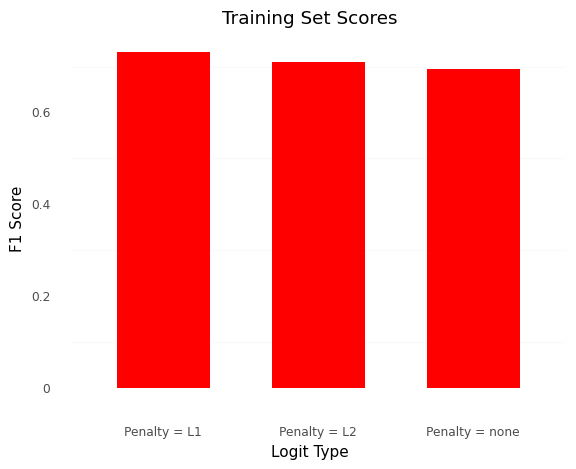

<ggplot: (8762711836748)>

In [ ]:
# representing the scores graphically

# train
(ggplot(train_df, aes(x = "Logit Type", y = "F1 Score")) +
 theme_minimal() +
 geom_bar(stat = "identity", width = 0.6, fill = "red") +
 theme(panel_grid_major_x = element_blank()) +
 theme(panel_grid_major_y = element_blank()) +
 ggtitle("Training Set Scores"))

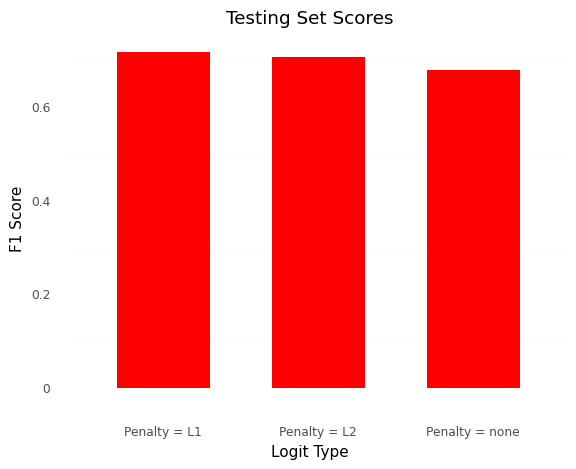

<ggplot: (8762712206403)>

In [ ]:
# test
(ggplot(test_df, aes(x = "Logit Type", y = "F1 Score")) +
 theme_minimal() +
 geom_bar(stat = "identity", width = 0.6, fill = "red") +
 theme(panel_grid_major_x = element_blank()) +
 theme(panel_grid_major_y = element_blank()) +
 ggtitle("Testing Set Scores"))

The L1 penalty (LASSO) model gave us the best f1 score, however all of the models produced f1 scores above 0.7.
In the LASSO model, none of the coefficients were dragged to zero: they all remainded relevant to the model. The lasso regularization penalty deems all of our predictors to "carry their weight," but it does add a significant penalty to many of the terms.

##O3
(Supervised Model) Build a decision tree classifier using a appropriate hyperparameter choice for min_samples_leaf and use all predictors except for HbA1c_level and blood_glucose_level. Now build another decision tree classifier using only those two predictors that were left out (with proper hyperparameter choice). Which model has the better recall score? (We are using recall because the consequences of false negatives are more costly than false positives). What does this say about the relationship between sugar and glucose levels in the blood and the odds of being diabetic?

In [ ]:
diabetes = pd.read_csv("diabetes_prediction_dataset.csv")
diabetes.dropna(inplace = True)
diabetes = pd.get_dummies(diabetes, columns = ["gender", "smoking_history"])



In [ ]:
# Decision Tree #1

# set predictors

p1 = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'gender_Female', 'gender_Male', 'gender_Other',
       'smoking_history_No Info', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current']

# train test split
X = diabetes[p1]
y = diabetes["diabetes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# create z score object 
z = make_column_transformer((StandardScaler(), p1),
                            remainder = "passthrough")

#create model
dt = DecisionTreeClassifier()

# create pipeline
pipe = make_pipeline(z, dt)
print(pipe.get_params().keys())

depths = {"decisiontreeclassifier__min_samples_leaf": range(10,20)}

#grid search 
grid1 = GridSearchCV(pipe, depths, scoring = "accuracy", cv = 5, refit = True)
grid1.fit(X_train, y_train)


dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'decisiontreeclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__standardscaler', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__random_state', 'decisiontreeclassi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'bmi',
                                                                          'HbA1c_level',
                                                                          'blood_glucose_level',
                                                                          'gender_Female',
                                                                          'gender_Male',
                                                                          'gender_Other',
                                                                          'smoking_history_No '
                                                                          'Info',
                                                                          'smoking_history_current',
                                                                          'smoking_history_ever',
                                                                          'smoking_history_former',
                                                                          'smoking_history_never',
                                                                          'smoking_history_not '
                                                                          'current'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__min_samples_leaf': range(10, 20)},
             scoring='accuracy')

In [ ]:
# metrics for DT #1
print("Train Recall: ", recall_score(y_train, grid1.predict(X_train)))
print("Test Recall: ",  recall_score(y_test, grid1.predict(X_test)))

Train Recall:  0.704173002196317
Test Recall:  0.6896551724137931


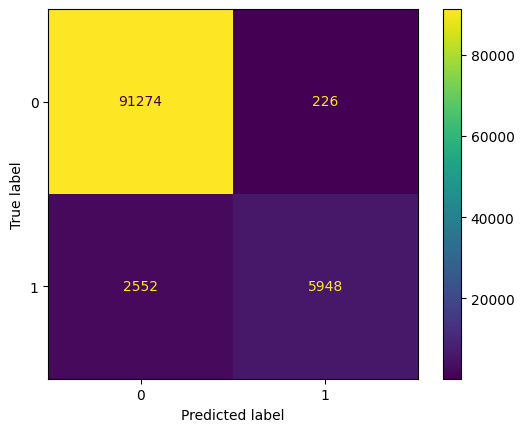

In [ ]:
# confusion matrix for DT #1
ConfusionMatrixDisplay.from_predictions(y, grid1.predict(X))

In [ ]:
# Decision Tree #2

# set predictors

p2 = ['HbA1c_level', 'blood_glucose_level']

# train test split
X = diabetes[p2]
y = diabetes["diabetes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# create z score object 
z = make_column_transformer((StandardScaler(), p2),
                            remainder = "passthrough")

#create model
dt = DecisionTreeClassifier()

# create pipeline
pipe = make_pipeline(z, dt)
print(pipe.get_params().keys())

depths = {"decisiontreeclassifier__min_samples_leaf": range(10,20)}

#grid search 
grid2 = GridSearchCV(pipe, depths, scoring = "accuracy", cv = 5, refit = True)
grid2.fit(X_train, y_train)

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'decisiontreeclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__standardscaler', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__random_state', 'decisiontreeclassi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['HbA1c_level',
                                                                          'blood_glucose_level'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__min_samples_leaf': range(10, 20)},
             scoring='accuracy')

In [ ]:
# metrics for DT #2
print("Train Recall: ", recall_score(y_train, grid2.predict(X_train)))
print("Test Recall: ",  recall_score(y_test, grid2.predict(X_test)))

Train Recall:  0.670841089862921
Test Recall:  0.6649942107294481


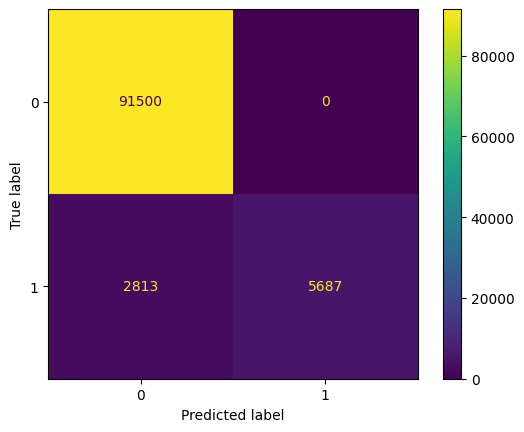

In [ ]:
# confusion matrix for DT #2

ConfusionMatrixDisplay.from_predictions(y, grid2.predict(X))

When comparing the 2 decision trees above, the one that included a majority of the predictors, decision tree 1, performed better. The recall scores for both models with very close, but the fist model was slightly higer. A higher recall score means a model is more accurate at making positive and negative predictions.
We now know that blood sugar levels and blood glucose levels are highly correlated with diabetes, but are do not complete the picture. We need the other predictors to make a good estimate.

##Q4
Question: (Ethics) What are the implications of using our best model as a sole decision maker for new patients? Which are more costly: false positives or false negatives? How confident can be be in our predictions?

In [ ]:
diabetes = pd.read_csv("diabetes_prediction_dataset.csv")
predictors = ["gender", "age", "hypertension", "heart_disease", "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"]
cont_predictors =  ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
outcome = "diabetes"
diabetes.dropna(inplace = True)
X = diabetes[predictors]
y = diabetes[outcome]
X = pd.get_dummies(X, columns = ["gender", "smoking_history"])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# 5 models in total to compare: No pealty logit, l1 logit, l2 logit, 
# decision tree w/ all predictors, and decision tree w/ blood sugar levels

#regular_logit
print("Logit with no Penalty")
print("Train Accuracy: ", regular_logit_accuracy_train)
print("Test Accuracy: ",  regular_logit_accuracy_test)
print("Train Recall: ", regular_logit_recall_train)
print("Test Recall: ",  regular_logit_recall_test)
print("Train f1: ", regular_logit_f1_train)
print("Test f1: ",  regular_logit_f1_test)

print("------------------------------------------------")
# l1_logit
print("Logit with L1 Penalty")
print("Train Accuracy: ", l1_logit_accuracy_train)
print("Test Accuracy: ",  l1_logit_accuracy_test)
print("Train Recall: ", l1_logit_recall_train)
print("Test Recall: ",  l1_logit_recall_test)
print("Train f1: ", l1_logit_f1_train)
print("Test f1: ",  l1_logit_f1_test)

print("------------------------------------------------")
# l2_logit
print("Logit with L2 Penalty")
print("Train Accuracy: ", l2_logit_accuracy_train)
print("Test Accuracy: ",  l2_logit_accuracy_test)
print("Train Recall: ", l2_logit_recall_train)
print("Test Recall: ",  l2_logit_recall_test)
print("Train f1: ", l2_logit_f1_train)
print("Test f1: ",  l2_logit_f1_test)




print("------------------------------------------------")
# Decision Tree 1
print("Decision Tree with all predictors")
print("Train Accuracy: ", accuracy_score(y_train, grid1.predict(X_train)))
print("Test Accuracy: ",  accuracy_score(y_test, grid1.predict(X_test)))
print("Train Recall: ", recall_score(y_train, grid1.predict(X_train)))
print("Test Recall: ",  recall_score(y_test, grid1.predict(X_test)))
print("Train f1: ", f1_score(y_train, grid1.predict(X_train)))
print("Test f1: ",  f1_score(y_test, grid1.predict(X_test)))


print("------------------------------------------------")
# Decision Tree 2
print("Decision Tree with only two predictors")
print("Train Accuracy: ", accuracy_score(y_train, grid2.predict(X_train)))
print("Test Accuracy: ",  accuracy_score(y_test, grid2.predict(X_test)))
print("Train Recall: ", recall_score(y_train, grid2.predict(X_train)))
print("Test Recall: ",  recall_score(y_test, grid2.predict(X_test)))
print("Train f1: ", f1_score(y_train, grid2.predict(X_train)))
print("Test f1: ",  f1_score(y_test, grid2.predict(X_test)))

Logit with no Penalty
Train Accuracy:  0.9558
Test Accuracy:  0.95465
Train Recall:  0.5881316098707403
Test Recall:  0.5768321513002365
Train f1:  0.6936936936936937
Test f1:  0.6827562084644981
------------------------------------------------
Logit with L1 Penalty
Train Accuracy:  0.9604625
Test Accuracy:  0.95965
Train Recall:  0.6307285546415982
Test Recall:  0.6117021276595744
Train f1:  0.7308314186026721
Test f1:  0.7194994786235662
------------------------------------------------
Logit with L2 Penalty
Train Accuracy:  0.957725
Test Accuracy:  0.95805
Train Recall:  0.6079612220916569
Test Recall:  0.6034278959810875
Train f1:  0.7099485420240137
Test f1:  0.7087816730301978
------------------------------------------------
Decision Tree with all predictors
Train Accuracy:  0.9722625
Test Accuracy:  0.97205
Train Recall:  0.7016590808985465
Test Recall:  0.6921255180580225
Train f1:  0.811581896917721
Test f1:  0.8070417673455298
------------------------------------------------
D

In [ ]:
# plotting recall

# making DFs so we can use ggplot
recallDF_train = pd.DataFrame({"Model": ["Regular logit", "L1 logit", "L2 logit", "DT1", "DT2"], "Training recall scores": [regular_logit_recall_train, l1_logit_recall_train, l2_logit_recall_train, recall_score(y_train, grid1.predict(X_train)), recall_score(y_train, grid2.predict(X_train))]})

recallDF_test = pd.DataFrame({"Model": ["Regular logit", "L1 logit", "L2 logit", "DT1", "DT2"], "Testing recall scores": [regular_logit_recall_test, l1_logit_recall_test, l2_logit_recall_test, recall_score(y_test, grid1.predict(X_test)), recall_score(y_test, grid2.predict(X_test))]})

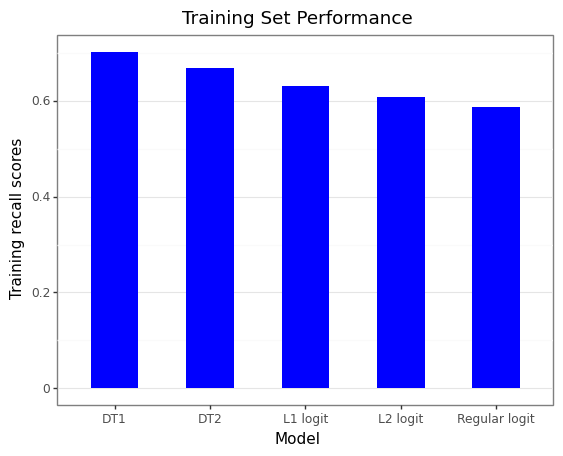

<ggplot: (8762712366975)>

In [ ]:
(ggplot(recallDF_train, aes(x = "Model", y = "Training recall scores")) + 
 geom_bar(fill = "blue", stat = "identity", width = 0.5) +
 theme_bw() + 
 theme(panel_grid_major_x = element_blank()) +
 ggtitle("Training Set Performance"))

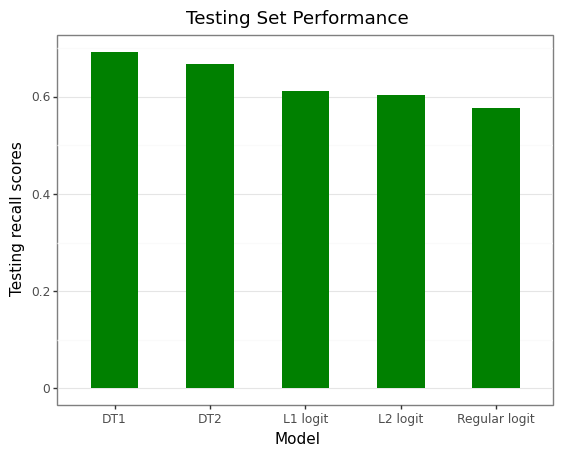

<ggplot: (8762712238183)>

In [ ]:
(ggplot(recallDF_test, aes(x = "Model", y = "Testing recall scores")) + 
 geom_bar(fill = "green", stat = "identity", width = 0.5) +
 theme_bw() + 
 theme(panel_grid_major_x = element_blank()) +
ggtitle("Testing Set Performance"))

### Best model for our use case: Decision tree with most predictors.

The most important metrics for this case is recall. F1 score and accuracy are equally important to us here.
Recall is the most important because this metric tell us what proportion of actual positives were classified correctly in our model. This is TP / (TP + FN). Our main goal is to reduce FN because this means we identify a patient as non-diabetic even though they are. This restricts access to life-altering medication that they need.
F1 score incorportes recall and precision so we have a good understanding of how often we misclassify a patient's condition. We are able to incorporate FNs and FPs with f1 score, providing us with information on how often we misclassify as a whole.
Accuracy is correct predictions / total predictions. We want to know the rate of correct predictions, so we use accuracy.

When using our best model to predict diabetes, we need to keep some serious ethical considerations in mind. Our predicted outcome lies within the category of “predictive analytics,” where we try to predict which patients will have either type 1 or type 2 diabetes. Our predictions are only a small step away from prescriptive analytics, where we recommend the kinds of treatment each patient should receive based on our predictions. Also, since our dataset does not differentiate between type 1 and type 2 diabetes, our model also cannot separate the two conditions and thus would not be able to effectively recommend a suitable treatment plan.

If our model were used in the medical field as the only diagnoser of diabetes, we would have serious problems. If there is a significant FPR or FNR, then we risk limiting access to life saving insulin treatment for those with type 1 diabetes. We want our model to have a high recall score because we do not tolerate false negatives. If we classify someone who is not diabetic as diabetic, they will likely soon realize they are not diabetic through blood sugar monitors. However, if we classify someone who is diabetic as not diabetic, they will not have access to an insulin pump which is necessary for proper functioning of people with type 1 diabetes (and sometimes type 2).


In [1]:
!pip install gwpy &> /dev/null

# installing necessary files
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

# installing pypandoc
!pip install pypandoc

# connecting your google drive
from google.colab import drive
drive.mount('/content/drive')

# copying your file over. Change "Class6-Completed.ipynb" to whatever your file is called (see top of notebook)
!cp "drive/My Drive/Colab Notebooks/CPSC392/FinalProject.ipynb" ./

# Again, replace "Class6-Completed.ipynb" to whatever your file is called (see top of notebook)
!jupyter nbconvert --to PDF "FinalProject.ipynb"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (2.5-3build2).
texlive is already the newest version (2019.20200218-1).
texlive-latex-extra is already the newest version (2019.202000218-1).
texlive-xetex is already the newest version (2019.20200218-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes